In [148]:
#| output: false
import smile_extract
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
from pathlib import Path
%matplotlib inline

trialframe_dir = Path('../data/trialframe')
dataset = 'Prez_2022-07-21'
composition_config_path = Path('../conf/trialframe.yaml')

In [149]:
composition_config = OmegaConf.load(composition_config_path)
tf = smile_extract.compose_from_frames(
    meta=pd.read_parquet(trialframe_dir / dataset / f'{dataset}_{composition_config.info}.parquet'),
    trialframe_dict={
        key: pd.read_parquet(trialframe_dir / dataset / f'{dataset}_{filepart}.parquet')
        for key, filepart in composition_config.composition.items()
    }
)
# tf

Let's convert the old PyalData format to a new hierarchical DataFrame format, keeping only the columns we need for now.

In [150]:
from src.munge import multivalue_xs, hierarchical_assign
from src.time_slice import reindex_trial_from_event
from src.timeseries import estimate_kinematic_derivative
state_mapper = {
    'Control System': 'Go Cue',
    'Reach to Target 1': 'Go Cue',
    'Hold at Target 1': 'Go Cue', # Sometimes first reach state is skipped in this table (if the first target is in the center)
    'Reach to Target': 'Go Cue',
}
preproc = (
    tf
    .set_index(['task','result','state'],append=True)
    [['hand position','motor cortex']]
    .pipe(multivalue_xs, level='task', keys=['CST','RTT'])
    .xs(level='result',key='success')
    .rename(index=state_mapper, level='state')
    .pipe(hierarchical_assign,{
        'hand velocity': lambda df: (
            df['hand position']
            .groupby('trial_id',group_keys=False)
            .apply(estimate_kinematic_derivative, deriv=1, cutoff=30)
        )
    })
    .groupby('trial_id', group_keys=False)
    .apply(lambda df: reindex_trial_from_event(df, event='Go Cue'))
)
preproc

signal                                                         hand position  \
channel                                                                    x   
block   trial_id time                     task state                           
cst-rtt 1        -1 days +23:59:56.780000 CST  Reach to Center     87.491912   
                 -1 days +23:59:56.790000 CST  Reach to Center     87.469056   
                 -1 days +23:59:56.800000 CST  Reach to Center     87.439185   
                 -1 days +23:59:56.810000 CST  Reach to Center     87.415315   
                 -1 days +23:59:56.820000 CST  Reach to Center     87.402561   
...                                                                      ...   
        393      0 days 00:00:03.730000   RTT  Success             67.763502   
                 0 days 00:00:03.740000   RTT  Success             67.669932   
                 0 days 00:00:03.750000   RTT  Success             67.611669   
                 0 days 00:00:03.760000   RTT  Success             67.594491   
                 0 days 00:00:03.770000   RTT  Success             67.606179   

signal                                                                      \
channel                                                                  y   
block   trial_id time                     task state                         
cst-rtt 1        -1 days +23:59:56.780000 CST  Reach to Center  619.951447   
                 -1 days +23:59:56.790000 CST  Reach to Center  619.949176   
                 -1 days +23:59:56.800000 CST  Reach to Center  619.957786   
                 -1 days +23:59:56.810000 CST  Reach to Center  619.952311   
                 -1 days +23:59:56.820000 CST  Reach to Center  619.936980   
...                                                                    ...   
        393      0 days 00:00:03.730000   RTT  Success          419.322178   
                 0 days 00:00:03.740000   RTT  Success          419.463506   
                 0 days 00:00:03.750000   RTT  Success          419.615849   
                 0 days 00:00:03.760000   RTT  Success          419.789580   
                 0 days 00:00:03.770000   RTT  Success          419.944687   

signal                                                                      \
channel                                                                  z   
block   trial_id time                     task state                         
cst-rtt 1        -1 days +23:59:56.780000 CST  Reach to Center -130.308794   
                 -1 days +23:59:56.790000 CST  Reach to Center -130.281867   
                 -1 days +23:59:56.800000 CST  Reach to Center -130.279259   
                 -1 days +23:59:56.810000 CST  Reach to Center -130.301029   
                 -1 days +23:59:56.820000 CST  Reach to Center -130.306830   
...                                                                    ...   
        393      0 days 00:00:03.730000   RTT  Success          -81.744767   
                 0 days 00:00:03.740000   RTT  Success          -81.846267   
                 0 days 00:00:03.750000   RTT  Success          -81.951281   
                 0 days 00:00:03.760000   RTT  Success          -82.064665   
                 0 days 00:00:03.770000   RTT  Success          -82.158297   

signal                                                         motor cortex  \
channel                                                               ch1u1   
block   trial_id time                     task state                          
cst-rtt 1        -1 days +23:59:56.780000 CST  Reach to Center    51.461798   
                 -1 days +23:59:56.790000 CST  Reach to Center    51.994735   
                 -1 days +23:59:56.800000 CST  Reach to Center    51.671714   
                 -1 days +23:59:56.810000 CST  Reach to Center    51.272362   
                 -1 days +23:59:56.820000 CST  Reach to Center    50.997663   
...                                                          

Need to figure out a way to extract the random target onsets indexed by the target number.

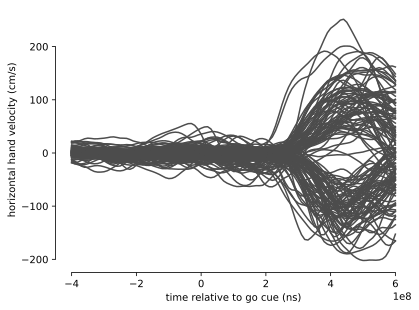

In [151]:
ax = sns.lineplot(
    data=(
        preproc
        .xs(level='task',key='RTT')
        .loc[(slice(None),slice(None),slice('-0.4s','0.6s')),:] # type: ignore
    ),
    x='time',
    y=('hand velocity','x'),
    units='trial_id',
    color='0.3',
    estimator=None,
    errorbar=None
)
sns.despine(ax=ax, trim=True)
ax.set_ylabel('horizontal hand velocity (cm/s)')
ax.set_xlabel('time relative to go cue (ns)')
plt.show()

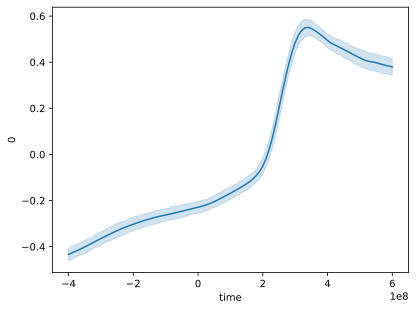

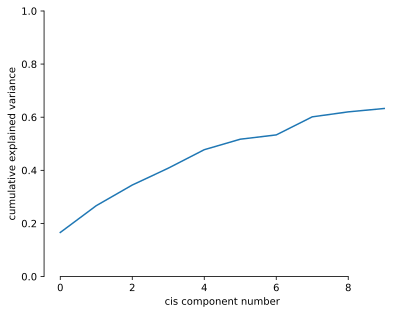

In [152]:
from sklearn.pipeline import Pipeline
from src.crystal_models import SoftnormScaler, BaselineShifter, TrialframeDPCA

preproc_pipeline = Pipeline([
    ('scaler', SoftnormScaler()),
    # ('baseline', BaselineShifter(ref_event='Hold Center (Ambiguous Cue)', ref_slice=slice('-0.3s','-0.05s'))),
])
dpca = TrialframeDPCA(
    labels='t',
    regularizer=None,
    protect=['t'],
)
neural_data = (
    preproc
    ['motor cortex']
    .pipe(preproc_pipeline.fit_transform)
    .dropna()
)
Z = (
    neural_data
    .xs(level='task',key='RTT')
    .loc[(slice(None),slice(None),slice('-0.4s','0.6s')),:]
    .pipe(dpca.fit_transform)
)

sns.lineplot(
    data=Z,
    x='time',
    y=0,
)
ax.set_xlabel('time relative to go cue (s)')
ax.set_ylabel('first condition invariant dimension')
sns.despine(ax=ax,trim=True)

fig,ax=plt.subplots()
ax.plot(
    np.cumsum(dpca.model.explained_variance_ratio_['t'])
)
ax.set_ylim([0,1])
ax.set_ylabel('cumulative explained variance')
ax.set_xlabel('cis component number')
sns.despine(ax=ax, trim=True)

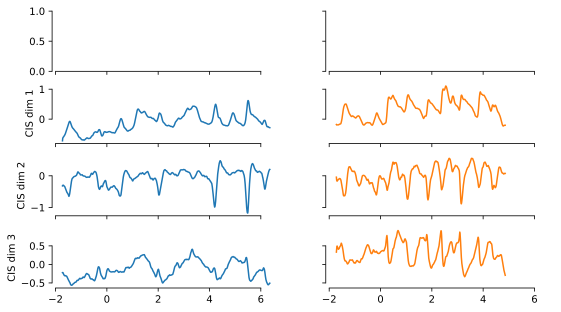

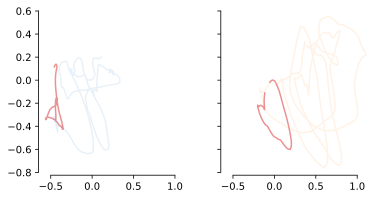

In [155]:
from src.time_slice import slice_by_time
from src.munge import get_index_level
from sklearn.model_selection import GroupShuffleSplit

gss = GroupShuffleSplit(
    n_splits=1,
    test_size=0.1,
)
cis = dpca.transform(neural_data)
_,sample_idx = next(gss.split(cis, groups=get_index_level(cis,'trial_id')))
cis_sampled = cis.iloc[sample_idx]

# trial_ids = [193,76]
trial_ids = [183,3]
# trial_ids = [76,354]
# trials_to_plot = multivalue_xs(preproc, level='trial_id', keys=trial_ids)
cis_sampled = multivalue_xs(cis, level='trial_id', keys=trial_ids)

fig,axs = plt.subplots(4,2,figsize=(9,5),sharex=True, sharey='row')
# for i,trial in trials_to_plot.reset_index().iterrows():
#     src.plot.plot_hand_trace(trial,ax=axs[0,i])
#     #axs[0,i].plot(reaction_time.loc[trial['trial_id']].total_seconds(),0,'ro')

for _,trial in cis_sampled.groupby('trial_id'):
    if trial.reset_index(level='task')['task'].values[0] == 'CST':
        axs[1,0].plot(get_index_level(trial,level='time')/np.timedelta64(1,'s'),trial[0],color='tab:blue')
        axs[2,0].plot(get_index_level(trial,level='time')/np.timedelta64(1,'s'),trial[1],color='tab:blue')
        axs[3,0].plot(get_index_level(trial,level='time')/np.timedelta64(1,'s'),trial[2],color='tab:blue')

        axs[1,0].set_ylabel('CIS dim 1')
        axs[2,0].set_ylabel('CIS dim 2')
        axs[3,0].set_ylabel('CIS dim 3')
    else:
        axs[1,1].plot(get_index_level(trial,level='time')/np.timedelta64(1,'s'),trial[0],color='tab:orange')
        axs[2,1].plot(get_index_level(trial,level='time')/np.timedelta64(1,'s'),trial[1],color='tab:orange')
        axs[3,1].plot(get_index_level(trial,level='time')/np.timedelta64(1,'s'),trial[2],color='tab:orange')

sns.despine(fig=fig,trim=True)

fig,axs = plt.subplots(1,2,figsize=(6,3),sharey=True,sharex=True)
for task,task_df in cis_sampled.groupby('task'):
    for _,trial in task_df.groupby('trial_id'):
        indices_to_drop = list(set(trial.index.names) - {'trial_id','time'})
        temp = trial.reset_index(level=indices_to_drop, drop=True)
        prego = slice_by_time(temp, time_slice=slice('-0.5s','0s'))
        postgo = slice_by_time(temp, time_slice=slice('0s','3s'))
        if task == 'CST':
            axs[0].plot(prego[0],prego[1],color='tab:red',alpha=0.5)
            axs[0].plot(postgo[0],postgo[1],color='tab:blue',alpha=0.1)
        elif task == 'RTT':
            axs[1].plot(prego[0],prego[1],color='tab:red',alpha=0.5)
            axs[1].plot(postgo[0],postgo[1],color='tab:orange',alpha=0.1)

sns.despine(fig=fig,trim=True)

# sns.relplot(
#     data=cis_sampled,
#     x='relative time',
#     y=1,
#     hue='task',
#     row='task',
#     kind='line',
#     units='trial_id',
#     estimator=None,
#     errorbar=None,
#     aspect=2,
# )

In [145]:
from pyaldata import get_onset_idx
reaction_time = (
    tf
    .pipe(src.munge.reindex_from_event_times,events.xs(key='goCue',level='event'),timecol='trial time')
    .xs(key='RTT',axis=0,level='task')
    .loc[(slice(None),slice('0.2s','0.6s')),:]
    .groupby('trial_id')
    .apply(lambda df: pd.to_timedelta(get_onset_idx(df[('hand_speed',0)])*10e-3 + 0.2,unit='s'))
)
# sns.lineplot(
#     data=(
#         tf
#         .pipe(src.munge.reindex_from_event_times,events.xs(key='goCue',level='event'),timecol='trial time')
#         .xs(key='RTT',axis=0,level='task')
#         .loc[(slice(None),slice('0s','0.6s')),:]
#         .loc[5,('hand_speed',0)]
#     ),
# )

neural_onset = (
    tf
    .pipe(src.munge.reindex_from_event_times,events.xs(key='goCue',level='event'),timecol='trial time')
    .pipe(lambda df: pd.DataFrame(
        dpca.transform(df['lfads_rates'].values.T,marginalization='t').T,
        index=df.index)
    )
    .xs(key='RTT',axis=0,level='task')
    .loc[(slice(None),slice('0.2s','0.6s')),:]
    .groupby('trial_id')
    .apply(lambda df: pd.to_timedelta(get_onset_idx(df.loc[:,0],min_ds=0.01)*10e-3 + 0.2,unit='s'))
)

# threshold = 0.1
# crossings = (
#     cis.loc[(slice(None),slice('0s',None)),0]
#     .gt(threshold)
#     .groupby('trial_id')
#     .idxmax()
#     .apply(lambda x: x[1])
# )
ax = sns.regplot(
    x=reaction_time.dt.total_seconds(),
    y=neural_onset.dt.total_seconds(),
    x_jitter=0.005,
    y_jitter=0.005,
    robust=True,
)
ax.set_aspect('equal')
reaction_time.corr(neural_onset)

ModuleNotFoundError: No module named 'pyaldata'

In [ ]:
np.cumsum(dpca.model.explained_variance_ratio_['t'])
# dpca.model.explained_variance_ratio_['t']

array([0.12099999, 0.20156728, 0.25385532, 0.32552772, 0.38118556,
       0.40631838, 0.42838594, 0.48410648, 0.50186538, 0.51720932])

In [ ]:
cis_sampled

0  \
block   trial_id task state             time                                 
cst-rtt 140      CST  Reach to Center   -1 days +23:59:58.430000  1.127386   
                                        -1 days +23:59:58.440000  0.992045   
                                        -1 days +23:59:58.450000  0.947658   
                                        -1 days +23:59:58.460000  0.920870   
                                        -1 days +23:59:58.470000  0.902625   
...                                                                    ...   
        228      RTT  Reach to Target 2 0 days 00:00:01.150000   -0.340787   
                                        0 days 00:00:01.160000   -0.319700   
        372      RTT  Hold at Target 5  0 days 00:00:03.810000   -0.247403   
        369      RTT  Hold at Target 8  0 days 00:00:04.370000    0.436971   
        353      RTT  Hold at Target 4  0 days 00:00:02.210000    0.057678   

                                                                         1  \
block   trial_id task state             time                                 
cst-rtt 140      CST  Reach to Center   -1 days +23:59:58.430000 -0.157609   
                                        -1 days +23:59:58.440000 -0.090303   
                                        -1 days +23:59:58.450000 -0.134882   
                                        -1 days +23:59:58.460000 -0.189398   
                                        -1 days +23:59:58.470000 -0.227592   
...                                                                    ...   
        228      RTT  Reach to Target 2 0 days 00:00:01.150000    0.598284   
                                        0 days 00:00:01.160000    0.584180   
        372      RTT  Hold at Target 5  0 days 00:00:03.810000    0.773629   
        369      RTT  Hold at Target 8  0 days 00:00:04.370000    0.229262   
        353      RTT  Hold at Target 4  0 days 00:00:02.210000    0.498608   

                                                                         2  \
block   trial_id task state             time                                 
cst-rtt 140      CST  Reach to Center   -1 days +23:59:58.430000 -0.101872   
                                        -1 days +23:59:58.440000 -0.151059   
                                        -1 days +23:59:58.450000 -0.119137   
                                        -1 days +23:59:58.460000 -0.070855   
                                        -1 days +23:59:58.470000 -0.041992   
...                                                                    ...   
        228      RTT  Reach to Target 2 0 days 00:00:01.150000    0.437455   
                                        0 days 00:00:01.160000    0.433992   
        372      RTT  Hold at Target 5  0 days 00:00:03.810000    0.397556   
        369      RTT  Hold at Target 8  0 days 00:00:04.370000    0.152241   
        353      RTT  Hold at Target 4  0 days 00:00:02.210000    0.246449   

                                                                         3  \
block   trial_id task state             time                                 
cst-rtt 140      CST  Reach to Center   -1 days +23:59:58.430000 -0.511563   
                                        -1 days +23:59:58.440000 -0.389976   
                                        -1 days +23:59:58.450000 -0.359251   
                                        -1 days +23:59:58.460000 -0.346508   
                                        -1 days +23:59:58.470000 -0.327827   
...                                                                    ...   
        228      RTT  Reach to Target 2 0 days 00:00:01.150000    0.807310   
                                        0 days 00:00:01.160000    0.812846   
        372      RTT  Hold at Target 5  0 days 00:00:03.810000    0.474981   
        369      RTT  Hold at Target 8  0 days 00:00:04.370000   -0.271167   
        353      RTT  Hold at Target 4  0 days 00:00:02.210000    0.252499   

             

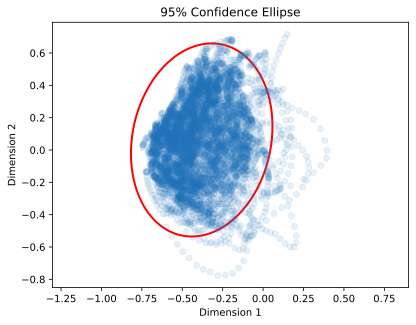

In [156]:
from matplotlib.patches import Ellipse

prego_cis = (
    cis
    .xs(level='task',key='RTT')
    .pipe(slice_by_time, time_slice=slice('-0.5s','0s'))
)
# prego_cis = cis.loc[(slice(None),slice('-0.5s','0s'),'RTT'),:]

# Assuming prego_cis is a DataFrame with at least two columns for the multidimensional data
data = prego_cis.values[:, :2]

# Calculate the mean of the data
mean = np.mean(data, axis=0)

# Calculate the covariance matrix
cov = np.cov(data, rowvar=False)

# Eigen decomposition
eigenvalues, eigenvectors = np.linalg.eigh(cov)

# Calculate the angle of the ellipse
angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))

# Calculate the width and height of the ellipse
width, height = 2 * np.sqrt(eigenvalues * 5.991)  # 5.991 is the chi-square value for 95% confidence

# Plotting the ellipse
fig, ax = plt.subplots()
ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle, edgecolor='r', fc='None', lw=2)
ax.add_patch(ellipse)

# Plot the data points
ax.scatter(data[:, 0], data[:, 1],alpha=0.1)

# Set the aspect ratio of the plot to be equal
ax.set_aspect('equal', 'datalim')

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('95% Confidence Ellipse')
plt.show()

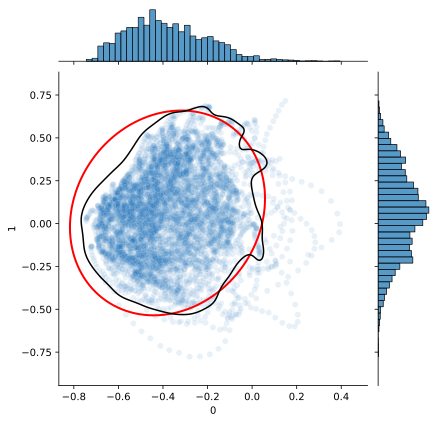

In [157]:
g = sns.jointplot(
    data=prego_cis,
    x=0,
    y=1,
    alpha=0.1,
)
g.plot_joint(sns.kdeplot, color='k', levels=[0.05])
ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle, edgecolor='r', fc='None', lw=2)
g.ax_joint.add_patch(ellipse)

In [158]:
from scipy.spatial.distance import mahalanobis,cdist

num_cis_dims = 4
prego_cis = (
    cis
    .xs(level='task',key='RTT')
    .pipe(slice_by_time, time_slice=slice('-0.5s','0s'))
)

def prego_mahal_distance(points: pd.DataFrame,num_dims=num_cis_dims) -> pd.DataFrame:
    assert num_dims <= prego_cis.shape[1], 'Number of dimensions exceeds number of dimensions in prego_cis'

    prego_mean = prego_cis.mean().values[np.newaxis,:num_dims]
    prego_cov = prego_cis.cov().values[:num_dims,:num_dims]
    
    return pd.DataFrame(
        cdist(points.loc[:,:(num_dims-1)],prego_mean,metric='mahalanobis',VI=np.linalg.pinv(prego_cov)),
        index=points.index,
    )

In [159]:
cis_mahal = (
    cis
    .xs(level='task',key='RTT')
    .pipe(slice_by_time, time_slice=slice('0.15s','1s'))
    .pipe(prego_mahal_distance)
    .squeeze()
    .rename('mahalanobis distance')
    .to_frame()
)

# sns.lineplot(
#     data=cis_mahal,
#     x='relative time',
#     y='mahalanobis distance',
#     units='trial_id',
#     estimator=None,
#     errorbar=None,
# )

threshold = 4.5
crossings = (
    cis_mahal
    .gt(threshold)
    .groupby('trial_id')
    .idxmax()
    .squeeze()
    .apply(lambda x: x[1])
)
ax = sns.regplot(
    x=reaction_time.dt.total_seconds(),
    y=crossings.dt.total_seconds(),
    x_jitter=0.005,
    y_jitter=0.005,
    robust=True,
)
ax.set_aspect('equal')
reaction_time.dt.total_seconds()
ax.set_xlabel('Reaction time (s)')
ax.set_ylabel('Neural onset (s)')
reaction_time.corr(crossings)

NameError: name 'reaction_time' is not defined

In [ ]:
reaction_time

In [ ]:
trial_ids = [193,76]
trial_ids = [183,3]
#trial_ids = [76,354]
trials_to_plot = td.set_index('trial_id').loc[trial_ids]
cis_sampled = cis.loc[trial_ids]

fig,axs = plt.subplots(4,2,figsize=(9,5),sharex=True, sharey='row')
for i,trial in trials_to_plot.reset_index().iterrows():
    src.plot.plot_hand_trace(trial,ax=axs[0,i])
    #axs[0,i].plot(reaction_time.loc[trial['trial_id']].total_seconds(),0,'ro')

for _,trial in cis_sampled.groupby('trial_id'):
    if trial.reset_index(level='task')['task'].values[0] == 'CST':
        axs[1,0].plot(trial.reset_index(level='relative time')['relative time']/np.timedelta64(1,'s'),trial[0],color='tab:blue')
        axs[2,0].plot(trial.reset_index(level='relative time')['relative time']/np.timedelta64(1,'s'),trial[1],color='tab:blue')
        axs[3,0].plot(trial.reset_index(level='relative time')['relative time']/np.timedelta64(1,'s'),trial[2],color='tab:blue')
    else:
        axs[1,1].plot(trial.reset_index(level='relative time')['relative time']/np.timedelta64(1,'s'),trial[0],color='tab:orange')
        axs[2,1].plot(trial.reset_index(level='relative time')['relative time']/np.timedelta64(1,'s'),trial[1],color='tab:orange')
        axs[3,1].plot(trial.reset_index(level='relative time')['relative time']/np.timedelta64(1,'s'),trial[2],color='tab:orange')

sns.despine(fig=fig,trim=True)

In [ ]:
cis_sampled

In [165]:
onset_signals

signal                                                          hand position  \
channel                                                                     x   
block   trial_id time                     state                                 
cst-rtt 2        -1 days +23:59:59.500000 Hold Center (RTT Cue)     59.522148   
                 -1 days +23:59:59.510000 Hold Center (RTT Cue)     59.615159   
                 -1 days +23:59:59.520000 Hold Center (RTT Cue)     59.703589   
                 -1 days +23:59:59.530000 Hold Center (RTT Cue)     59.786742   
                 -1 days +23:59:59.540000 Hold Center (RTT Cue)     59.830242   
...                                                                       ...   
        393      0 days 00:00:00.560000   Go Cue                    73.150714   
                 0 days 00:00:00.570000   Go Cue                    73.830542   
                 0 days 00:00:00.580000   Go Cue                    74.489383   
                 0 days 00:00:00.590000   Go Cue                    75.139273   
                 0 days 00:00:00.600000   Go Cue                    75.777302   

signal                                                                       \
channel                                                                   y   
block   trial_id time                     state                               
cst-rtt 2        -1 days +23:59:59.500000 Hold Center (RTT Cue)  416.786151   
                 -1 days +23:59:59.510000 Hold Center (RTT Cue)  416.746536   
                 -1 days +23:59:59.520000 Hold Center (RTT Cue)  416.751392   
                 -1 days +23:59:59.530000 Hold Center (RTT Cue)  416.828752   
                 -1 days +23:59:59.540000 Hold Center (RTT Cue)  416.929277   
...                                                                     ...   
        393      0 days 00:00:00.560000   Go Cue                 421.689433   
                 0 days 00:00:00.570000   Go Cue                 421.798954   
                 0 days 00:00:00.580000   Go Cue                 421.882266   
                 0 days 00:00:00.590000   Go Cue                 421.924617   
                 0 days 00:00:00.600000   Go Cue                 421.953700   

signal                                                                      \
channel                                                                  z   
block   trial_id time                     state                              
cst-rtt 2        -1 days +23:59:59.500000 Hold Center (RTT Cue)  -2.687094   
                 -1 days +23:59:59.510000 Hold Center (RTT Cue)  -2.607672   
                 -1 days +23:59:59.520000 Hold Center (RTT Cue)  -2.598173   
                 -1 days +23:59:59.530000 Hold Center (RTT Cue)  -2.658973   
                 -1 days +23:59:59.540000 Hold Center (RTT Cue)  -2.639530   
...                                                                    ...   
        393      0 days 00:00:00.560000   Go Cue                -84.601720   
                 0 days 00:00:00.570000   Go Cue                -84.538397   
                 0 days 00:00:00.580000   Go Cue                -84.481569   
                 0 days 00:00:00.590000   Go Cue                -84.431701   
                 0 days 00:00:00.600000   Go Cue                -84.406244   

signal                                                          motor cortex  \
channel                                                                ch1u1   
block   trial_id time                     state                                
cst-rtt 2        -1 days +23:59:59.500000 Hold Center (RTT Cue)    69.584632   
                 -1 days +23:59:59.510000 Hold Center (RTT Cue)    69.300252   
                 -1 days +23:59:59.520000 Hold Center (RTT Cue)    68.868148   
                 -1 days +23:59:59.530000 Hold Center (RTT Cue)    68.385184   
                 -1 days +23:59:59.540000 Hold Center (RTT Cue)    68.033868   
...                      

In [164]:
onset_signals = (
    preproc
    .xs(key='RTT',axis=0,level='task')
    .pipe(slice_by_time, time_slice=slice('-0.5s','0.6s'))
    .pipe(hierarchical_assign,{
        'cis': lambda df: dpca.transform(df['motor cortex'])
    })
    .assign(**{
        'cis mahalanobis distance': lambda df: prego_mahal_distance(df['cis']),
    })
    # .assign(**{
    #     'hand_speed': lambda df: df['hand velocity'].apply(lambda x: np.linalg.norm(x,axis=1)),
    # })
    # [['hand_speed','cis mahalanobis distance']]
    # .droplevel('channel',axis=1)
    # .assign(**{
    #     'dhand_speed': lambda x: x['hand_speed'].diff(),
    #     'dmahal': lambda x: x['cis mahalanobis distance'].diff(),
    # })
)

# reaction_time = (
#     onset_signals
#     .loc[(slice(None),slice('0.1s','0.5s')),:]
#     .groupby('trial_id')
#     .apply(lambda df: pd.to_timedelta(get_onset_idx(df['hand_speed'])*10e-3 + 0.1,unit='s'))
# )
peak_acc_time = (
    onset_signals
    .pipe(slice_by_time, time_slice=slice('0.1s','0.5s'))
    ['dhand_speed']
    .groupby('trial_id')
    .idxmax()
    .apply(lambda x: x[1])
)

# neural_onset = (
#     onset_signals
#     .loc[(slice(None),slice('0.1s','0.5s')),:]
#     .groupby('trial_id')
#     .apply(lambda df: pd.to_timedelta(get_onset_idx(df['cis mahalanobis distance'],min_ds=0.01)*10e-3 + 0.1,unit='s'))
# )
peak_dmahal = (
    onset_signals
    .pipe(slice_by_time, time_slice=slice('0.1s','0.5s'))
    ['dmahal']
    .groupby('trial_id')
    .idxmax()
    .apply(lambda x: x[1])
)

# num_trials_to_plot = 10
# g = sns.relplot(
#     data=(
#         onset_signals
#         .loc[(slice(None),slice('-0.2s','0.5s')),:]
#         .pipe(src.crystal.sample_trials,timecol='relative time',n=num_trials_to_plot)
#         .stack(level='signal')
#         .astype(float)
#         .rename('value')
#         .reset_index()
#         .assign(**{
#             'relative time': lambda x: x['relative time'].dt.total_seconds(),
#         })
#     ),
#     x='relative time',
#     y='value',
#     col='trial_id',
#     row='signal',
#     kind='line',
#     aspect=1.5,
#     height=2,
#     facet_kws={
#         'sharey':'row',
#     },
# )
# g.refline(x=0,linestyle='-',color='k')
# for (signal,trial_id),ax in g.axes_dict.items():
#     if signal == 'hand_speed' or signal == 'dhand_speed':
#         ax.axvline(peak_acc_time.loc[trial_id].total_seconds(),color='r',linestyle='--')
#     elif signal == 'cis mahalanobis distance' or signal == 'dmahal':
#         # ax.axhline(4.5,color='k',linestyle='--')
#         ax.axvline(peak_dmahal.loc[trial_id].total_seconds(),color='r',linestyle='--')
#     # ax.plot(reaction_time.loc[trial_id].total_seconds(),0,'ro')

KeyError: 'dhand_speed'

In [ ]:
ax = sns.regplot(
    x=peak_acc_time.dt.total_seconds(),
    y=peak_dmahal.dt.total_seconds(),
    x_jitter=0.002,
    y_jitter=0.002,
    robust=True,
)
ax.plot([0.1,0.5],[0.1,0.5],'k--')
ax.set_xlabel('Peak acceleration time (s)')
ax.set_ylabel('Peak dMahalanobis time (s)')
ax.set_xlim(0.1,0.5)
ax.set_ylim(0.1,0.5)
ax.set_aspect('equal')
sns.despine(ax=ax,trim=True,)
peak_dmahal.corr(peak_acc_time)

In [187]:
temp.assign(hand_speed= lambda df: np.linalg.norm(df['hand velocity'],axis=1))

signal                                                         hand position  \
channel                                                                    x   
block   trial_id time                     task state                           
cst-rtt 1        -1 days +23:59:56.780000 CST  Reach to Center     87.491912   
                 -1 days +23:59:56.790000 CST  Reach to Center     87.469056   
                 -1 days +23:59:56.800000 CST  Reach to Center     87.439185   
                 -1 days +23:59:56.810000 CST  Reach to Center     87.415315   
                 -1 days +23:59:56.820000 CST  Reach to Center     87.402561   
...                                                                      ...   
        393      0 days 00:00:03.730000   RTT  Success             67.763502   
                 0 days 00:00:03.740000   RTT  Success             67.669932   
                 0 days 00:00:03.750000   RTT  Success             67.611669   
                 0 days 00:00:03.760000   RTT  Success             67.594491   
                 0 days 00:00:03.770000   RTT  Success             67.606179   

signal                                                                      \
channel                                                                  y   
block   trial_id time                     task state                         
cst-rtt 1        -1 days +23:59:56.780000 CST  Reach to Center  619.951447   
                 -1 days +23:59:56.790000 CST  Reach to Center  619.949176   
                 -1 days +23:59:56.800000 CST  Reach to Center  619.957786   
                 -1 days +23:59:56.810000 CST  Reach to Center  619.952311   
                 -1 days +23:59:56.820000 CST  Reach to Center  619.936980   
...                                                                    ...   
        393      0 days 00:00:03.730000   RTT  Success          419.322178   
                 0 days 00:00:03.740000   RTT  Success          419.463506   
                 0 days 00:00:03.750000   RTT  Success          419.615849   
                 0 days 00:00:03.760000   RTT  Success          419.789580   
                 0 days 00:00:03.770000   RTT  Success          419.944687   

signal                                                                      \
channel                                                                  z   
block   trial_id time                     task state                         
cst-rtt 1        -1 days +23:59:56.780000 CST  Reach to Center -130.308794   
                 -1 days +23:59:56.790000 CST  Reach to Center -130.281867   
                 -1 days +23:59:56.800000 CST  Reach to Center -130.279259   
                 -1 days +23:59:56.810000 CST  Reach to Center -130.301029   
                 -1 days +23:59:56.820000 CST  Reach to Center -130.306830   
...                                                                    ...   
        393      0 days 00:00:03.730000   RTT  Success          -81.744767   
                 0 days 00:00:03.740000   RTT  Success          -81.846267   
                 0 days 00:00:03.750000   RTT  Success          -81.951281   
                 0 days 00:00:03.760000   RTT  Success          -82.064665   
                 0 days 00:00:03.770000   RTT  Success          -82.158297   

signal                                                         motor cortex  \
channel                                                               ch1u1   
block   trial_id time                     task state                          
cst-rtt 1        -1 days +23:59:56.780000 CST  Reach to Center    51.461798   
                 -1 days +23:59:56.790000 CST  Reach to Center    51.994735   
                 -1 days +23:59:56.800000 CST  Reach to Center    51.671714   
                 -1 days +23:59:56.810000 CST  Reach to Center    51.272362   
                 -1 days +23:59:56.820000 CST  Reach to Center    50.997663   
...                                                          

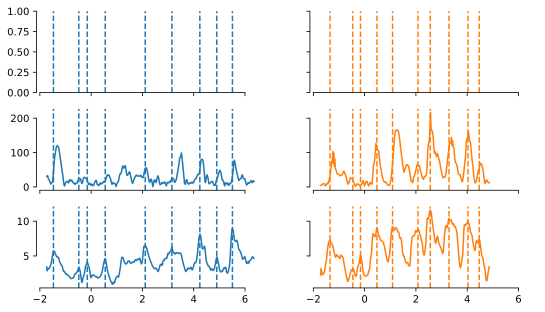

In [188]:
from scipy.signal import find_peaks

# trial_ids = [193,76]
trial_ids = [183,3]
# trials_to_plot = td.set_index('trial_id').loc[trial_ids]
temp = (
    preproc
    .pipe(hierarchical_assign,{
        'cis': lambda df: (
            df['motor cortex']
            .pipe(preproc_pipeline.transform)
            .pipe(dpca.transform)
        )
    })
    .assign(**{
        'cis mahalanobis distance': lambda df: prego_mahal_distance(df['cis']),
    })
)
cis_sampled= (
    temp
    .assign(**{
        'hand_speed': lambda df: np.linalg.norm(df['hand velocity'],axis=1),
    })
    [['hand_speed','cis mahalanobis distance']]
    .droplevel('channel',axis=1)
    .assign(**{
        'dhand_speed': lambda x: x['hand_speed'].diff(),
        'dmahal': lambda df: df['cis mahalanobis distance'].groupby('trial_id').transform(lambda x: x.diff()),
    })
    .pipe(multivalue_xs, level='trial_id', keys=trial_ids)
)

fig,axs = plt.subplots(3,2,figsize=(9,5),sharex=True, sharey='row')
# for i,trial in trials_to_plot.reset_index().iterrows():
#     src.plot.plot_hand_trace(trial,ax=axs[0,i])
#     #axs[0,i].plot(reaction_time.loc[trial['trial_id']].total_seconds(),0,'ro')

for _,trial in cis_sampled.groupby('trial_id'):
    if trial.reset_index(level='task')['task'].values[0] == 'CST':
        col=0
        color='tab:blue'
    else:
        col=1
        color='tab:orange'

    axs[1,col].plot(get_index_level(trial,level='time')/np.timedelta64(1,'s'),trial['hand_speed'],color=color)
    axs[2,col].plot(get_index_level(trial,level='time')/np.timedelta64(1,'s'),trial['cis mahalanobis distance'],color=color)

    peaks, props = find_peaks(trial['cis mahalanobis distance'],prominence=1)
    # peaks, props = find_peaks(trial['dmahal'],prominence=1)
    for peak in peaks:
        for row in range(3):
            axs[row,col].axvline(get_index_level(trial,level='time').values[peak]/np.timedelta64(1,'s'),color=color,linestyle='--')

sns.despine(fig=fig,trim=True)

In [ ]:
def find_peak_index(s: pd.Series,timecol: str='relative time',**kwargs):
    peak_idx,_ = find_peaks(s,**kwargs)
    return (
        s
        .reset_index(level=timecol)
        [timecol]
        .iloc[peak_idx]
    )

cis_peaks= (
    tf
    .pipe(src.munge.reindex_from_event_times,events.xs(key='ctHold',level='event'),timecol='trial time')
    ['lfads_rates']
    .pipe(
        lambda df: pd.DataFrame(
            dpca.transform(df.values.T,marginalization='t').T,
            index=df.index
        ),
    )
    .pipe(prego_mahal_distance)
    .squeeze()
    .rename('cis mahalanobis distance')
    .pipe(find_peak_index,prominence=1)
    .rename('cis peak times')
    .loc[lambda x: x > pd.Timedelta(0)]
    .to_frame()
    .assign(**{
        'peak number': lambda x: x.groupby('trial_id').cumcount(),
    })
    .set_index('peak number',append=True)
    .squeeze()
)
print(cis_peaks.loc[76])
print(target_times.loc[76])

In [ ]:
temp = (
    cis_peaks
    .groupby('peak number')
    .apply(lambda x: src.munge.reindex_from_event_times(
        tf,
        x.reset_index(level='peak number',drop=True),
        timecol='trial time'
    ))
    .loc[(slice(None),slice(None),slice('-0.5s','0.5s')),:]
)

ax = sns.lineplot(
    data=temp.reset_index().assign(**{'snip id': lambda x: x['trial_id'].astype(str) + '_' + x['peak number'].astype(str)}),
    x='relative time',
    y=('hand_speed',0),
    hue='task',
    # units='snip id',
    # estimator=None,
    # errorbar=None,
    # lw=0.5,
    errorbar='ci',
)
ax.set_ylabel('horizontal hand speed (cm/s)')
ax.set_xlabel('time relative to peak CIS (ns)')
sns.despine(ax=ax,trim=True)

In [ ]:
temp = (
    (cis_peaks + pd.to_timedelta(np.random.normal(0,0.5,cis_peaks.shape),unit='s').round('10ms'))
    .groupby('peak number')
    .apply(lambda x: src.munge.reindex_from_event_times(
        tf,
        x.reset_index(level='peak number',drop=True),
        timecol='trial time'
    ))
    .loc[(slice(None),slice(None),slice('-0.5s','0.5s')),:]
)

ax = sns.lineplot(
    data=temp,
    x='relative time',
    y=('hand_speed',0),
    hue='task',
    # units='snip id',
    # estimator=None,
    # errorbar=None,
    # lw=0.5,
    errorbar='ci',
)
ax.set_ylabel('horizontal hand speed (cm/s)')
ax.set_xlabel('time relative to jittered peak CIS (ns)')
sns.despine(ax=ax,trim=True)

In [ ]:
(
    cis_peaks
    + pd.TimedeltaIndex(np.random.normal(0,0.5,cis_peaks.shape),unit='s').round('10ms')
)

In [ ]:
## looking for preparatory activity using varimax on neural activity around first go cue of RTT trials

from sklearn.decomposition import PCA

def get_move_directions(df: pd.DataFrame) -> pd.Series:
    return (
        df
        # .pipe(src.munge.reindex_from_event_times,events.xs(key='goCue',level='event'),timecol='trial time')
        [('hand_vel',0)]
        .groupby('trial_id')
        .agg('mean')
        .map(lambda x: 'left' if x < 0 else 'right')
        .rename('move direction')
    )

temp = (
    tf
    .pipe(src.munge.reindex_from_event_times,events.xs(key='goCue',level='event'),timecol='trial time')
    .xs(key='RTT',axis=0,level='task')
    .loc[(slice(None),slice('0s','0.6s')),:]
    .reset_index(level='relative time')
    .assign(**{
        'move direction': get_move_directions,
    })
    .set_index(['move direction','relative time'],append=True)
    .groupby(['move direction','relative time'])
    .mean()
    .pipe(src.munge.hierarchical_assign,{
        'lfads pca': lambda df: pd.DataFrame(
            PCA(n_components=10).fit_transform(df['lfads_rates']),
            index=df.index
        ),
    })
    .pipe(src.munge.hierarchical_assign,{
        'varimax pca': lambda df: pd.DataFrame(
            src.crystal_models.VarimaxTransformer().fit_transform(df['lfads pca']),
            index=df.index
        ),
    })
)
sns.relplot(
    data=temp['varimax pca'].stack(level='channel').rename('value').to_frame(),
    x='relative time',
    y='value',
    row='channel',
    hue='move direction',
    kind='line',
)

In [ ]:
events.loc[76]

In [ ]:
tf

In [ ]:
trial_ids = [193,76]

trials_to_plot = td.set_index('trial_id').loc[trial_ids]
temp = (
    tf
    .pipe(src.munge.reindex_from_event_times,events.xs(key='goCue',level='event'),timecol='trial time')
    .loc[(trial_ids,slice('0s','4s')),:]
)

# fig, axs = plt.subplots(1,2,figsize=(8,4),sharex=True,sharey=True)
# for i,(_,trial) in enumerate(temp.groupby('trial_id')):
#     axs[i].plot(trial[('rel_hand_pos',0)],trial[('hand_vel',0)])

trials_to_plot['rt_locations']
target_times.loc[trial_ids]

def get_current_target_location(trial_id: int, trial_time: pd.Timedelta) -> float:
    trial_targets = target_times.loc[trial_id]

    if pd.isna(trial_targets.loc[0,'location']): # there's only one target, i.e. it's a CST trial
        return np.nan

    if trial_time < trial_targets['target onset'].values[0]:
        return 0

    for target_num,target_info in trial_targets.iterrows():
        if trial_time >= target_info['target onset'] and trial_time < target_info['target acquisition']:
            return target_info['location']

    return np.nan

def get_current_target_number(trial_id: int, trial_time: pd.Timedelta) -> int:
    trial_targets = target_times.loc[trial_id]

    if pd.isna(trial_targets.loc[0,'location']): # there's only one target, i.e. it's a CST trial
        return 0

    if trial_time < trial_targets['target onset'].values[0]:
        return 0

    for target_num,target_info in trial_targets.iterrows():
        if trial_time >= target_info['target onset'] and trial_time <= target_info['target acquisition']:
            return int(target_num)

    return 8

temp = (
    tf
    .loc[trial_ids]
    .assign(**{
        'target location': lambda df: (
            df
            .apply(lambda x: get_current_target_location(x.name[0],x.name[2]),axis=1)
        ),
        'target number': lambda df: (
            df
            .apply(lambda x: get_current_target_number(x.name[0],x.name[2]),axis=1)
        ),
    })
)
# sns.scatterplot(
#     data=temp.loc[76],
#     x=('target location',''),
#     y=('rel_hand_pos',0),
# )

sns.relplot(
    data=(
        temp
        .filter(items=[('rel_hand_pos',0),('hand_vel',0),('target location',''),('target number','')])
        .droplevel(1,axis=1)
    ),
    x='rel_hand_pos',
    y='hand_vel',
    col='task',
    hue='target number',
    kind='scatter',
    palette='tab10',
)


In [ ]:
# align on peak CIS signal and average snippets
